# Project 1: Fire Extinguisher
Rishabh Patel and Eva Allred




## Implementation of the game

The entire game is run within the Ship class, which sets up the layout of the ship, navigates the spread of the fire, contains implementations of the four different bots, and runs simulations of the game. An example run of the game follows the code.

In [ ]:
import random
import copy
from collections import defaultdict, deque
import queue
import matplotlib.pyplot as plt
import heapq
import pickle
BLOCKED = 0
OPEN = 1
FIRE = 2
BOT = 3
BUTTON = 4
FLAMMABLE = set([OPEN, BOT, BUTTON])

In [ ]:
class Ship:
  BOT_START = 0
  FIRE_START = 1
  BUTTON_START = 2

  def __init__(self, size, a = 0.1, b = 0.3):
    """Creates a ship
    Parameters
    ----------
    size : int
        The size of the ship

    """
    self.size = size
    self.ship = self.make_ship(size)
    self.start_locs = self.choose_start_locs()
    self.set_board()
    self.bot_path = []
    self.fire_spreads = {}
    self.borders = {}
    self.turn = 0
    self.a = a
    self.b = b
    self.debug = False
    self.past = set()


  def get_fires(self, q, turn):
    """ Returns the cells on fire on this turn of the game
    Parameters
    ----------
    q : double
        The flammability parameter
    turn: int
        The current step of the game we are on
    Returns
    -------
    A set of the cells on fire in this turn
    """
    if q in self.fire_spreads: return self.fire_spreads[q][turn]
    self.compute_fires(q)
    return self.fire_spreads[q][turn]


  def get_borders(self, q, turn):
    """ Returns the cells neighboring fire cells on this turn of the game
    Parameters
    ----------
    q : double
        The flammability parameter
    turn: int
        The current step of the game we are on
    Returns
    -------
    A set of the cells neighboring fire cells in this turn
    """
    if q in self.borders: return self.borders[q][turn]
    self.compute_fires(q)
    return self.borders[q][turn]


  def compute_fires(self, q):
    """Computes the spread of the fire for a given flammability parameter
    Parameters
    ----------
    q : double
        The flammability parameter
    """
    fires = [set([self.start_locs[self.FIRE_START]])]

    fire_border = defaultdict(int)
    x, y = self.start_locs[self.FIRE_START]
    if x < self.size-1 and self.ship[x+1][y] in FLAMMABLE: fire_border[(x+1, y)] += 1
    if x > 0 and self.ship[x-1][y] in FLAMMABLE: fire_border[(x-1, y)] += 1
    if y < self.size-1 and self.ship[x][y+1] in FLAMMABLE: fire_border[(x, y+1)] += 1
    if y > 0 and self.ship[x][y-1] in FLAMMABLE: fire_border[(x, y-1)] += 1

    borders = [copy.deepcopy(fire_border)]
    burning = fires[0].copy()

    while True:
      removes = set()
      adds = set()
      # loop through cells that may catch fire
      for loc in fire_border:
        prob = 1-((1-q)**fire_border[loc])
        if random.random() < prob:
          # updating fire border and burning set
          burning.add(loc)
          removes.add(loc)
          x, y, = loc

          if x < self.size-1 and self.ship[x+1][y] in FLAMMABLE and (x+1, y) not in burning: adds.add((x+1, y))
          if x > 0 and self.ship[x-1][y] in FLAMMABLE and (x-1, y) not in burning: adds.add((x-1, y))
          if y < self.size-1 and self.ship[x][y+1] in FLAMMABLE and (x, y+1) not in burning: adds.add((x, y+1))
          if y > 0 and self.ship[x][y-1] in FLAMMABLE and (x, y-1) not in burning: adds.add((x, y-1))

      for loc in removes:
        fire_border.pop(loc)

      for loc in adds:
        fire_border[loc] += 1

      borders.append(copy.deepcopy(fire_border))

      fires.append(burning.copy())
      if self.start_locs[self.BUTTON_START] in burning:
        self.fire_spreads[q] = fires
        self.borders[q] = borders
        return


  def choose_start_locs(self):
    """Chooses the starting locations for the bot, fire, and button
    Returns
    -------
    start_locs : list
        A list of the starting locations
    """
    start_locs = random.sample(list(self.get_open_cells()),k=3)
    return start_locs


  def clear_board(self):
    """Returns all non-blocked cells to open
    """
    for i in range(self.size):
      for j in range(self.size):
        if self.ship[i][j] != BLOCKED: self.ship[i][j] = OPEN
        return


  def set_board(self):
    """Places the bot, fire, and button on the board and initializes the fire_border
    """
    self.clear_board()
    self.ship[self.start_locs[self.BOT_START][0]][self.start_locs[self.BOT_START][1]] = BOT
    self.ship[self.start_locs[self.FIRE_START][0]][self.start_locs[self.FIRE_START][1]] = FIRE
    self.ship[self.start_locs[self.BUTTON_START][0]][self.start_locs[self.BUTTON_START][1]] = BUTTON
    self.bot_loc = self.start_locs[self.BOT_START]

    self.fire_border = defaultdict(int)
    x, y = self.start_locs[self.FIRE_START]
    if x < self.size-1 and self.ship[x+1][y] == OPEN: self.fire_border[(x+1, y)] += 1
    if x > 0 and self.ship[x-1][y] == OPEN: self.fire_border[(x-1, y)] += 1
    if y < self.size-1 and self.ship[x][y+1] == OPEN: self.fire_border[(x, y+1)] += 1
    if y > 0 and self.ship[x][y-1] == OPEN: self.fire_border[(x, y-1)] += 1

    self.fire_cells = set([(self.start_locs[self.FIRE_START])])

    self.bot_path = []
    self.turn = 0
    return


  def make_ship(self, size):
    """Generates a grid of open/closed cells to serve as the ship
    Parameters
    ----------
    size : int
        The size of the ship
    Returns
    -------
    ship : list
        A list representing the ship
    """

    ship = [[BLOCKED for _ in range(size)] for i in range(size)]

    def get_blocked_neighbors(x, y):
      neighbors = set()
      if x < size-1 and ship[x+1][y] == BLOCKED: neighbors.add((x+1, y))
      if x > 0 and ship[x-1][y] == BLOCKED: neighbors.add((x-1, y))
      if y < size-1 and ship[x][y+1] == BLOCKED: neighbors.add((x, y+1))
      if y > 0 and ship[x][y-1] == BLOCKED: neighbors.add((x, y-1))
      return neighbors

    one_neighbor_fringe = set()
    multi_neighbor_cells = set()
    x, y = random.randint(0,size-1), random.randint(0,size-1)
    ship[x][y] = OPEN
    one_neighbor_fringe.update(get_blocked_neighbors(x, y))

    while one_neighbor_fringe:
      x, y = random.choice(list(one_neighbor_fringe))
      ship[x][y] = OPEN
      one_neighbor_fringe.remove((x, y))
      for neighbor in get_blocked_neighbors(x, y):
        if neighbor in one_neighbor_fringe:
          one_neighbor_fringe.remove(neighbor)
          multi_neighbor_cells.add(neighbor)
        else:
          if neighbor not in multi_neighbor_cells: one_neighbor_fringe.add(neighbor)

    #final step
    dead_end_cells = set()
    for i in range(size):
      for j in range(size):
        if ship[i][j] == OPEN and len(get_blocked_neighbors(i, j)) == 3:
          dead_end_cells.add((i, j))

    for i, j in dead_end_cells:
      if random.random() < 0.5 and len(get_blocked_neighbors(i, j)) > 1:
        closed_neighbor = random.choice(list(get_blocked_neighbors(i, j)))
        ship[closed_neighbor[0]][closed_neighbor[1]] = OPEN

    return ship


  def get_ship(self):
    """Returns the ship
    Returns
    -------
    ship : list
        A list representing the ship
    """
    return self.ship


  def print_layout(self, q):
    """Prints the ship
    """
    temp = {BLOCKED:'█',OPEN:' ',FIRE:'X',BUTTON:'B', BOT:'O'}

    for i in range(self.size):
      print('|',end='')
      # print(*[temp[x] for x in self.ship[i]],sep='|',end='')
      for j in range(self.size):
        if self.ship[i][j] == BLOCKED:
          print('█', end='')
          print('|', end='')
          continue
        cell = (i, j)
        if cell in self.get_fires(q, self.turn): print('X', end='')
        elif cell == self.bot_loc: print('O', end='')
        elif cell == self.start_locs[self.BUTTON_START]: print('B', end='')
        elif cell == self.start_locs[self.BOT_START]: print('□', end='')
        elif cell in self.past: print('~', end='')
        else: print(' ', end='')
        print('|', end='')
      print()


  def get_open_cells(self):
    """Returns the open cells in the ship
    Returns
    -------
    open_cells : set
        A set of tuples representing the open cells
    """
    open_cells = set()
    for i in range(self.size):
      for j in range(self.size):
        if self.ship[i][j]==OPEN: open_cells.add((i,j))
    return open_cells


  def next_move(self, bot_type, q):
    """Simulates one move forward.
    Parameters
    ----------
    bot_type : int
      The type of bot to use
    q : double
      The flammability parameter
    Returns
    -------
    Tuple containing the cell of the bot's next move
    """
    if bot_type == 1: return self.move_bot_1(q)
    elif bot_type == 2: return self.move_bot_2(q)
    elif bot_type == 3: return self.move_bot_3(q)
    elif bot_type == 4: return self.move_bot_4(q)


  def move_bot_1(self, q):
    """Gets the next move for bot 1: runs bfs to determine the path on the first
    turn, then returns the next move from this path when called.
    Parameters
    ----------
    q : double
        The flammability parameter
    Returns
    -------
    Tuple containing the cell of the bot's next move
    """
    if not self.bot_path:
      if not self.bfs2(self.start_locs[self.FIRE_START]):
        return False
    return self.bot_path.pop(0)

  def move_bot_2(self, q):
    """Gets the next move for bot 2. Checks its current path. If there are any
    fire cells in the current path, regenerate the path by calling bfs with
    restricted cells being the current fire cells.
    Parameters
    ----------
    q : double
        The flammability parameter
    Returns
    -------
    Tuple containing the cell of the bot's next move
    """
    for move in self.bot_path:
      if move in self.get_fires(q, self.turn):
        self.bot_path = []
        break

    if not self.bot_path:
      if not self.bfs2(self.get_fires(q, self.turn)):
        return False
    return self.bot_path.pop(0)


  def move_bot_3(self, q):
    """Gets the next move for bot 3. Checks its current path. If there are any
    fire cells or fire cell neighbors in its current path, regenerate the path.
    The bot tries to find a path that avoids all fire cells and fire cell
    neighbors using bfs. If this is not possible, the bot just returns a path
    avoiding fire cells.
    Parameters
    ----------
    q : double
        The flammability parameter
    Returns
    -------
    Tuple containing the cell of the bot's next move
    """
    for move in self.bot_path:
      if move in self.get_fires(q, self.turn).union(self.borders[q][self.turn]):
        self.bot_path = []
        break

    if not self.bot_path:
      if not self.bfs2(self.get_fires(q, self.turn).union(self.borders[q][self.turn])):
        if not self.bfs2(self.get_fires(q, self.turn)):
          return False
    return self.bot_path.pop(0)


  def move_bot_4(self, q):
    """Gets the next move for bot 4
    Parameters
    ----------
    q : double
        The flammability parameter
    Returns
    -------
    Tuple containing the cell of the bot's next move
    """
    if not self.ufcs(q):
      return False
    return self.bot_path.pop(0)


  def get_unblocked_neighbors(self, x, y):
    """Given a cell, finds its unblocked neighbors
    Parameters
    ----------
    x,y : ints
        The coordinates of the cell
    Returns
    -------
    neighbors : set
        A set of the unblocked neighbors of the cell
    """
    neighbors = set()
    if x < self.size-1 and self.ship[x+1][y] != BLOCKED: neighbors.add((x+1, y))
    if x > 0 and self.ship[x-1][y] != BLOCKED: neighbors.add((x-1, y))
    if y < self.size-1 and self.ship[x][y+1] != BLOCKED: neighbors.add((x, y+1))
    if y > 0 and self.ship[x][y-1] != BLOCKED: neighbors.add((x, y-1))
    return neighbors


  def bfs2(self, restricted_cells):
    """Finds the shortest path from the bot to the button, avoiding the restricted cells,
    updating the bot_path with the determined path.
    Parameters
    ----------
    restricted_cells : set
        A set containing the cells the path must not contain
    Returns
    -------
    True if a path was found, False otherwise
    """
    if self.start_locs[self.BUTTON_START] in restricted_cells: return False
    q1 = queue.deque()
    q1.appendleft(self.bot_loc)
    prev1 = {}
    v1 = set([self.bot_loc])
    q2 = queue.deque()
    q2.appendleft(self.start_locs[self.BUTTON_START])
    prev2 = {}
    v2 = set([self.start_locs[self.BUTTON_START]])

    prev1[self.bot_loc] = None
    prev2[self.start_locs[self.BUTTON_START]] = None
    while q1 or q2:
      for _ in range(len(q1)):
        x, y = q1.pop()
        neighbors = self.get_unblocked_neighbors(x, y)
        for neighbor in neighbors:
          if neighbor in restricted_cells or neighbor in v1: continue
          prev1[neighbor] = (x, y)
          q1.appendleft(neighbor)
          v1.add(neighbor)
          if neighbor in q2:
            self.bot_path = self.get_path(prev1, self.bot_loc, (x, y))[2:]  + self.get_path(prev2, self.start_locs[self.BUTTON_START], neighbor)[:0:-1]
            return True

      for _ in range(len(q2)):
        x, y = q2.pop()
        neighbors = self.get_unblocked_neighbors(x, y)
        for neighbor in neighbors:
          if neighbor in restricted_cells or neighbor in v2: continue
          q2.appendleft(neighbor)
          prev2[neighbor] = (x, y)
          v2.add(neighbor)
          if neighbor in q1:
            self.bot_path = self.get_path(prev1, self.bot_loc, neighbor)[2:]  + self.get_path(prev2, self.start_locs[self.BUTTON_START], (x, y))[:0:-1]
            return True
    return False


  def ufcs(self, q):
    """Finds the minimal cost path from the bot to the button (used by bot 4)
    Parameters
    ----------
    q : double
        The flammability parameter
    Returns
    -------
    True if a path was found, false otherwise
    """
    if q>=0.1 and q<=0.5: self.b = 2
    else: self.b = 0.15
    def get_cost(k):
      return self.a + k*(self.b)

    distances = {}
    distances[self.bot_loc] = 0
    prev = {}
    fringe = []
    heapq.heappush(fringe, (0, self.bot_loc))
    prev[self.bot_loc] = None

    while fringe:
      priority, cell = heapq.heappop(fringe)

      if cell == self.start_locs[self.BUTTON_START]:
        self.bot_path = self.get_path(prev, self.bot_loc, cell)[2:]
        return True
      for neighbor in self.get_unblocked_neighbors(cell[0], cell[1]):
        if neighbor in self.get_fires(q,self.turn): continue

        if neighbor not in self.get_borders(q, self.turn): k = 0
        else: k = self.get_borders(q, self.turn)[neighbor]

        temp_priority = priority + get_cost(k)

        if neighbor not in distances or temp_priority < distances[neighbor]:
          distances[neighbor] = temp_priority
          prev[neighbor] = cell
          heapq.heappush(fringe, (temp_priority, neighbor))

    return False


  # params: prev (the dictionary returned by the bfs method)
  # returns: the (shortest) path from the bot's location to the button
  def get_path(self, prev, start, finish):
    """Given the prev hashmap from bfs, determine the path from the bot's
    location to the button
    Parameters
    ----------
    prev : hashmap
        A hashmap mapping each cell in the path to its parent cell
    start : tuple
       the starting location of the path
    finish : tuple
        the ending location of the path
    Returns
    -------
    The path from the bot's current location to the button
    """
    path = []
    current = finish
    path.append(current)
    while current != None:
      path.append(prev[current])
      current = prev[current]
    path.reverse()
    return path


  def move_bot(self, movex, movey):
    """Updates the bot's current location and stores its old location
    Parameters
    ----------
    movex, movey : ints
        The location of the cell that the bot is moving to
    """
    self.ship[self.bot_loc[0]][self.bot_loc[1]] = OPEN
    self.past.add(self.bot_loc)
    self.bot_loc = (movex,movey)
    self.ship[self.bot_loc[0]][self.bot_loc[1]] = BOT


  def compute_possible(self, q):
    """Returns whether there is some possible path to the button
    Parameters
    ----------
    q : double
        The flammability parameter
    Returns
    -------
    True if dfs returns True, false otherwise
    """
    if self.dfs(q): return True
    return False


  def dfs(self, q):
    """Determines whether there is at least one path to the button, taking
    into account the spread of the fire
    Parameters
    ----------
    q : double
        The flammability parameter
    Returns
    -------
    True if there exists a path, false otherwise
    """
    fringe = [(self.start_locs[self.BOT_START],-1)]
    v = set()
    prev = {}

    if not q in self.fire_spreads.keys(): self.compute_fires(q)

    num_steps_til_fire_kills_button = len(self.fire_spreads[q])

    while len(fringe)!=0:
      curr = fringe.pop()
      x,y = curr[0]
      step = curr[1]

      if (x,y) ==  self.start_locs[self.BUTTON_START]:
        return True

      neighbors = self.get_unblocked_neighbors(x,y)

      for neighbor in neighbors:
        if step+1 == num_steps_til_fire_kills_button: continue
        if neighbor in self.fire_spreads[q][step+1] or (neighbor,step+1) in v: continue
        prev[neighbor]=(x,y)
        fringe.append((neighbor,step+1))
        v.add((neighbor,step+1))

    return False


  def run_sim(self, flammability, bot_type, print_states):
    """Runs a simulation of the game
    Parameters
    ----------
    flammability : double
        The flammability parameter
    bot_type : int
        The type of the bot (1, 2, 3, or 4)
    print_states: boolean
        True to print out information about the run, False otherwise
    Returns
    -------
    flag : int
        A number representing the outcome of the game:
        - 1: No valid path found by the bot's algorithm
        - 2: Bot successfully reached the button
        - 3: The bot walked into the fire
        - 4: The fire spread into the bot
        - 5: The fire spread into the button
    """
    self.set_board()

    while True:

      if print_states: print(f'turn: {self.turn}')

      if print_states:
        self.print_layout(flammability)
        print()

      if self.debug: print(self.turn)

      move = self.next_move(bot_type, flammability)

      if self.debug: print(move)

      if self.debug: print(self.bot_path)

      if not move:
        if print_states: print("no valid path")
        flag = 1
        break

      movex, movey = move

      if self.ship[movex][movey] == BUTTON:
        if print_states: print("reached button")
        flag = 2
        break

      if move in self.get_fires(flammability, self.turn):
        if print_states: print("Walked into fire")
        flag = 3
        break

      if self.debug: print(self.bot_loc)
      self.move_bot(movex, movey)

      if move in self.get_fires(flammability, self.turn + 1):
        if print_states: print("Fire spread into bot")
        flag = 4
        break

      if self.start_locs[self.BUTTON_START] in self.get_fires(flammability, self.turn + 1):
        if print_states: print("Fire spread into button")
        flag = 5
        break

      self.turn += 1

    return flag



In [ ]:
# fix a random seed for reproducibility
random.seed(7)
# create a ship of size 40x40
example = Ship(40)
# run a simulation with flammability parameter 0.5, using bot 2,
# printing the board on each turn to see how the bot moves
example.run_sim(0.5,2,True)

turn: 0
| | |█| |█| |█| |█| |█|█| | | |█|█| | | | |█| | | | | | | | | |█|█|█| | |█| |█| |
| |█| | |█| | | | | | | |█| |█| |█| | |█|█| | |█|█| |█|█| |█|█| | | | |█| | |█| |
| |█| |█| |█|█|█| | |█| |█| |█| | |█| | | |█| |█|█| | | | | | | | |█| | | |█|█| |
| | | |█| |█| | | |█| | |█| | |█| | | | | | | | | | |█| |█| | |█| | |█| |█|█| | |
| |█|█| | |█| |█| | |█| | | | | | | | | | |█|█| |█| | |█|█|█| |█|█| | | | | | |█|
| |█|█|█| | | | |█| |█| |█| |█| |█| |█|█| | |█|█|█| | |█| | | | | |█| |█|█|█| | |
| | | |█|█| | | | | |█| | | | | |█| | |█| | | | |█|█| | | |█| |█| | | | | | |█| |
| |█| | | | |█| | | | | |█|█| |█| |█| |█| |█|█| | |█| | |█| | | |█| | | |█| | |█|
| | | |█|X|█| |█|█|█|█| |█| | | | | | | | |█| | | | |█| | | |█| | | |█| | |█| | |
| |█|█| |█| | | |█| | | | | |█| | | | |█|█| | | |█| | | | | | | |█| | |█| |█|█| |
| |█| |B| |█|█| | |█| |█|█| |█| | |█|█|█| | |█| | |█|█| | |█| | | | |█| | | | |█|
| |█| | | | | |█| |█| | | |█| | | |█| | | | | | | | | | |█|█| | | |█|█| | |█| | |
| | | | 

5

## Question 1: Bot 4 Algorithm
*Q: Explain the design and algorithm for your Bot 4, being as specific as possible as to what your bot is actually
doing. How does your bot factor in the available information to make more informed decisions about what to
do next?*\
\
(Direct answer below)
\
\
Bots 1, 2, and 3 try to thread the needle between finding a short path to the button and staying away from the fire. Bot 1 is on one extreme, where it completely ignores the spreading of the fire and just heads on the most direct path to the button. Bot 2 takes some information about the fire into account, and replans its path each turn to avoid the current fire cells, and Bot 3 is even more risk averse: where possible, it avoids not only the current fire cells but also the fire cell neighbors. This means that bot 3 is able to mostly avoid being killed by the fire, but this strategy could lead it on overly circuitious routes, and end up taking so long that the fire reaches the button before the bot can. Sometimes, even though there is some risk to walking through a cell neighboring the fire, it is worth it because the path to the button is that much shorter. \
\
We used this idea to motivate our bot 4 algorithm. How can we balance finding the shortest path to the button while avoiding unnecessary risk by walking near fire? How can we quantify the risk of moving to any particular cell? \
\
We decided to think of the ship as a weighted graph. Each cell is a node, and the edge between each node and a neighbor has some weight, representing the cost of that move. Each move has some small base cost and a cost that is dependent on how likely the cell is to catch fire. The more neighbors on fire a cell has, the more likely it is to catch fire, so this cost is proportional to the number of neighbors on fire. This cost can be represented as $C=a+K*b$ where $a$ is a small base cost, $K$ is the number of neighbors on fire, and $b$ is a coefficient representing how risk-averse we want to be. Higher $b$ means that the bot will will be more "afraid" of the fire. \
\
Through experimentation with various values of $a$ and $b$, we settled on $a=0.1$ as the small base cost for a move, and $b=2$ for $0.1\leq q\leq0.5$ and $b=0.15$ for $q$ otherwise. Though this may seem arbitrary, it provided the best results across many trials. It is somewhat counterintuitive that $b$ is higher for smaller $q$, but I believe it makes sense because the bot can afford to be more risk averse around the fire when it is spreading slowly since there are more open cells. When the fire is spreading quickly (high $q$), the number of open paths shrinks faster and so the bot has to take more risks. Having $b$ be too high in this situation prevents the bot from finding a quick path to the button.\
\
Using this formula for cost, we use the UFCS algorithm as described in class as the algorithm to determine bot 4's path. Each turn, bot 4 runs UFCS again (so as to incorporate the new information about which cells are on fire) to determine its path. As shown in class, UFCS will find the minimal cost path, so bot 4 will find the path that has the minimal cost (which can also be thought of as minimal risk) to the button. Since moves that do not involve fire just have a small base cost, this algorithm still prioritizes shorter paths, but it will provide a longer path if it allows the bot to avoid dangerous cells. \
\
We hoped that this algorithm would provide a better balance between finding a short path but not taking too many risks by coming close to the fire. Our method of encoding risk in this way allows the bot to have more flexibility its moves than bot 3 has with its more rigid rules.
\
\
\
Summary: Bot 4 functions using UFCS. The priority function is calculated using an estimate of the cost of going to a specific cell. We modeled the cost of taking any move as a slight constant cost, $a$,  plus a cost, $b$, for each burning cell that neighbors the move, $K$. Thus the cost of a move is computed as $a + b*K$. The idea here is to penalize long paths, preventing unnecessary detours that may leave time for the fire to reach the button. At the same time, the formula associates a higher cost to a cell for each burning neighbor, so the cost scales with the chance that the cell catches fire.

This cost function is used directly within the standard UFCS algorithm taken straight from the notes. This means that it computes the path to the button that minimizes the total cost for all moves.




## Question 2: Running a bunch of simulations
*Q: For each bot, repeatedly generate test environments and evaluate the performance of the bot, for many values of q between 0 and 1. Graph the probability (or average frequency, rather) of the bot successfully putting out the fire. Be sure to repeat the experiment enough times to get accurate results for each bot, and each tested value of q*.\
A: Fixing a random seed (so as to allow consistency between tests) we tested all four bots on 1000 different ship layouts (of size 40), with 10 values of $q$ for each ship layout. As the code takes a few minutes to run, we pickle the result. We submitted the pickle of the data along with the code for reproducibility (to check our results without having to recompute the data, simply skip the next code cell and run the ones following).

In [ ]:
size = 40
qs = [i*0.1 for i in range(1,10)]
data = []
debug = False
for i in range(0,1000):
  random.seed(i)
  test = Ship(size)
  hash = {}
  for q in qs:
    hash[q] = [test.run_sim(q,1, debug), test.run_sim(q,2, debug), test.run_sim(q, 3, debug),test.run_sim(q,4,debug),test.compute_possible(q)]
  data.append(copy.deepcopy(hash))
with open('bots1234_v4.pkl','wb') as f:
  pickle.dump(data,f)
from google.colab import files
files.download('bots1234_v4.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 We then computed the average frequency of the bot successfully putting out the fire for each value of $q$. A plot displaying these frequencies is shown below:

In [ ]:
with open('bots1234_v4.pkl','rb') as f:
  data = pickle.load(f)

In [ ]:
qs = [i*0.1 for i in range(1,10)]
### Get success vs q data for each bot

# flags
b1f = {q:[data[i][q][0] for i in range(1000)] for q in qs}
b2f = {q:[data[i][q][1] for i in range(1000)] for q in qs}
b3f = {q:[data[i][q][2] for i in range(1000)] for q in qs}
b4f = {q:[data[i][q][3] for i in range(1000)] for q in qs}
poss1 = {q:[data[i][q][4] for i in range(1000)] for q in qs}

# successes
b1s = {q:[b1f[q][i] == 2 for i in range(1000)] for q in b1f}
b2s = {q:[b2f[q][i] == 2 for i in range(1000)] for q in b1f}
b3s = {q:[b3f[q][i] == 2 for i in range(1000)] for q in b1f}
b4s = {q:[b4f[q][i] == 2 for i in range(1000)] for q in b1f}

# flags where possible
b1fp = {q:[data[i][q][0] for i in range(1000) if poss1[q][i]] for q in qs}
b2fp = {q:[data[i][q][1] for i in range(1000) if poss1[q][i]] for q in qs}
b3fp = {q:[data[i][q][2] for i in range(1000) if poss1[q][i]] for q in qs}
b4fp = {q:[data[i][q][3] for i in range(1000) if poss1[q][i]] for q in qs}

#successes where possible
b1sp = {q:[b1fp[q][i] == 2 for i in range(len(b1fp[q]))] for q in b1fp}
b2sp = {q:[b2fp[q][i] == 2 for i in range(len(b2fp[q]))] for q in b2fp}
b3sp = {q:[b3fp[q][i] == 2 for i in range(len(b3fp[q]))] for q in b3fp}
b4sp = {q:[b4fp[q][i] == 2 for i in range(len(b4fp[q]))] for q in b4fp}

avgs = [{key:sum(val)/len(val) for key, val in b1s.items()}, {key:sum(val)/len(val) for key, val in b2s.items()}, {key:sum(val)/len(val) for key, val in b3s.items()},{key:sum(val)/len(val) for key, val in b4s.items()}]
avgsp = [{key:sum(val)/len(val) for key, val in b1sp.items()}, {key:sum(val)/len(val) for key, val in b2sp.items()}, {key:sum(val)/len(val) for key, val in b3sp.items()},{key:sum(val)/len(val) for key, val in b4sp.items()}]

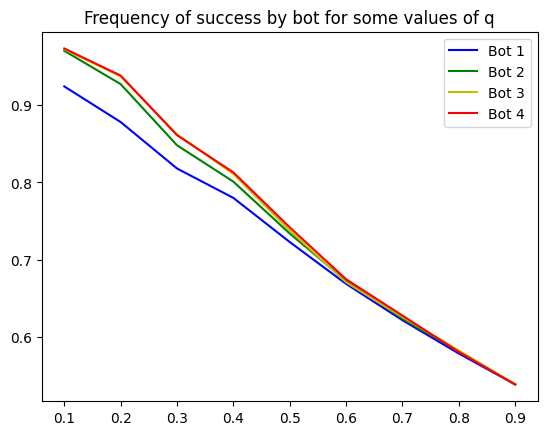

In [ ]:
plt.figure()
plt.plot(list(avgs[0].keys()),list(avgs[0].values()), 'b')
plt.plot(list(avgs[1].keys()),list(avgs[1].values()), 'g')
plt.plot(list(avgs[2].keys()),list(avgs[2].values()), 'y')
plt.plot(list(avgs[3].keys()),list(avgs[3].values()), 'r')
plt.title('Frequency of success by bot for some values of q')
plt.legend(['Bot 1','Bot 2', 'Bot 3', 'Bot 4']);

We see that for low $q$, bot 1 is significantly worse than the rest, with bots 2 and 3 having very similiar frequencies of success. Bot 4 has a slightly higher frequency of success. As $q$ increases, the frequency of success of the bots becomes essentially the same.\
\
It is also important to note that for some ship layouts, it is not possible for any bot to find a solution. If we can determine whether there are possible solutions for the various ship layouts, then we can compute the average frequency of the bot successfully putting out the fire in ships where there is a possible solution, which will give us a better understanding of the bot's performance.\
\
We compute whether there is a possible solution for a given ship layout by running a modified DFS search. Note that we precompute the spread of the fire for the given ship layout and flammability parameter when initializing the ship (though of course, the bot does not have access to how the fire will spread in the future, only the fire's current status). We run DFS on the ship layout, taking into account the spread of the fire, starting from the bot's initial position and terminating when the button is found or all possible paths have been exhausted. We take into account the spread of the fire by storing extra information on each cell on the fringe. Instead of just saving a cell's coordinates to the fringe, we also store the step of the game that the cell was reached by DFS. Then, when exploring that cell's neighbors, we check whether there will be fire in the neighbor on the following turn (which we can do because we precomputed the spread of the fire). We only add a neighbor to the fringe if it will not be on fire in the following step. In this way, if DFS finds a path to the button, it is guaranteed that this path “outruns” the fire and that if followed exactly by the bot, the bot will successfully make it to the button. Of course, because DFS uses the knowledge about where the fire will spread, we cannot use the results as a path for the bot.
But we know that if DFS finds a path, there is a possible solution for a given ship layout and fire spread, and we can use this to judge the performance of the bot.\
 \
  Below is a graph comparing the average frequency of success out of games that had a possible solution for the four bots across various values of q.


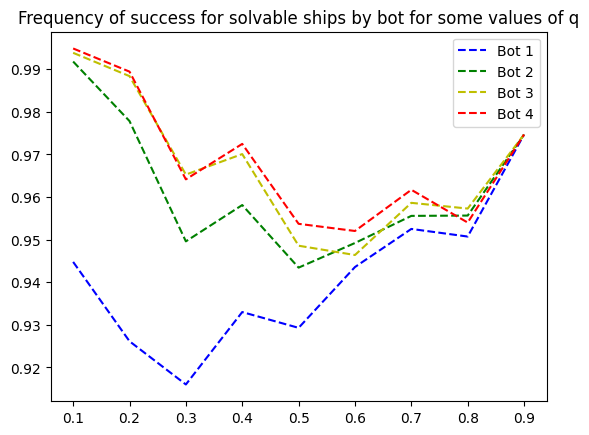

In [ ]:
plt.figure()
plt.plot(list(avgsp[0].keys()),list(avgsp[0].values()), 'b--')
plt.plot(list(avgsp[1].keys()),list(avgsp[1].values()), 'g--')
plt.plot(list(avgsp[2].keys()),list(avgsp[2].values()), 'y--')
plt.plot(list(avgsp[3].keys()),list(avgsp[3].values()), 'r--')
plt.title('Frequency of success for solvable ships by bot for some values of q')
plt.legend(['Bot 1','Bot 2', 'Bot 3', 'Bot 4']);

We see that all bots are relatively successful for ships that have a solution, with all bots having success rates over 90% for all values of $q$. For $q<0.5$ we have that bot 1 is the least successful, followed by bot 2, and bots 3 and 4 having similar success rates. Bots 2, 3, and 4 generally decrease in their success rates from $q=0.1$ to $q=0.5$, and the success rates of all bots increases from $q=0.5$ to $q=0.9$. This seems counterintuitive; the bots should become less successful as the flammability parameter increases because the fire spreads more quickly. We suspect that the rate increases because there are many fewer ships that are solvable at the higher $q$ values and so the ships that are left are "easy," as in the bot is close to the button at the start.   

## Question 3: When and why do the bots fail?
*Q: When bots fail or get trapped by the fire, why do they fail? Was there a better decision they could have made that would have saved them? Why or why not? Support your conclusions.*\
The situations that cause a bot to fail depend on the type of the bot. We analyze the flags returned by the failed simulations in order to get an understanding of what situations cause each bot to fail. Note that we only analyze games that had a possible solution, since there isn't much to learn from looking at the games that are impossible for any bot. The meaning of the flags is as follows:

1.   No valid path found by the bot's algorithm
2.   The bot reached the button (will not be present in this analysis because we are only looking at bots that fail)
3.   The bot walked into the fire
4.   The fire spread into the bot
5.   The fire spread into the button.

The analysis follows the code.





In [ ]:
import pandas as pd
poss1 = {q:[data[i][q][4] for i in range(1000)] for q in qs}
num_of_impossible_boards={q:[i for i in range(1000) if data[i][q][4]==False] for q in qs}
bot1_fails = {q:[i for i in range(1000) if (i not in num_of_impossible_boards[q] and data[i][q][0]!=2)] for q in qs}
bot2_fails = {q:[i for i in range(1000) if (i not in num_of_impossible_boards[q] and data[i][q][1]!=2)] for q in qs}
bot3_fails = {q:[i for i in range(1000) if (i not in num_of_impossible_boards[q] and data[i][q][2]!=2)] for q in qs}
bot4_fails = {q:[i for i in range(1000) if (i not in num_of_impossible_boards[q] and data[i][q][3]!=2)] for q in qs}
df=pd.DataFrame([['1',0,0,0,0],['3',0,0,0,0],['4',0,0,0,0],['5',0,0,0,0]],
                columns=['Flag','Bot 1 Count','Bot 2 Count','Bot 3 Count','Bot 4 Count'])
df.set_index('Flag',inplace=True)

for q in qs:
  for i in bot1_fails[q]:
    df.loc[str(data[i][q][0]),'Bot 1 Count']+=1


for q in qs:
  for i in bot2_fails[q]:
    df.loc[str(data[i][q][1]),'Bot 2 Count']+=1

for q in qs:
  for i in bot3_fails[q]:
    df.loc[str(data[i][q][2]),'Bot 3 Count']+=1

for q in qs:
  for i in bot4_fails[q]:
    df.loc[str(data[i][q][3]),'Bot 4 Count']+=1

df


,Bot 1 Count,Bot 2 Count,Bot 3 Count,Bot 4 Count
Flag,,,,
1,0,39,92,57
3,245,0,0,0
4,180,194,53,107
5,0,26,73,43


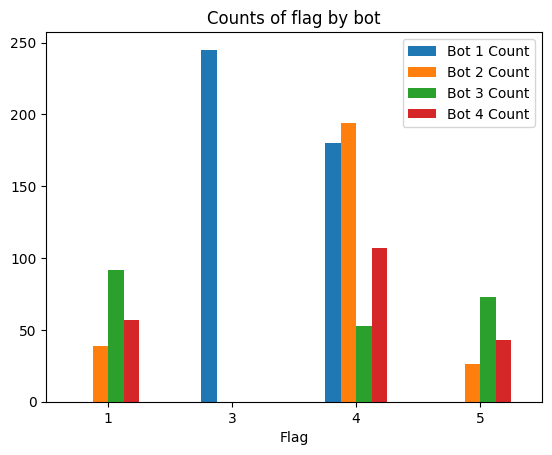

In [ ]:
df.plot(kind='bar',stacked=False,title='Counts of flag by bot',rot=0);

**Bot 1**\
Bot 1 fails because it just simply walks into the fire (flag 3), or else the fire spreads into it (flag 4) because the spread of the fire is ignored by the bot. There was always a better decision that could have saved the bot, namely to avoid walking into the fire by replanning the route based on where the fire is currently. None of the other bots die from walking into the fire because they replan based on the fire's current location.


**Bot 2**\
Bot 2 most often dies from the fire spreading into the bot (flag 4). This makes sense because bot 2 does not take into account where the fire might spread; it just avoids the current fire cells. So, if its path brings it near the fire, there's a chance that the fire spreads into it and kills it. This could be avoided if the bot took into account what cells were near fires in planning its path. Much less common is the fire spreading into the button, which happens because the bot didn't reach it in time (flag 5). The other reason this bot failed was because its algorithm (BFS) couldn't find a valid path to the button (flag 1). This means that at some point in the game, the bot encountered a situation where there was no possible way to reach the button. This is likely because the initial route chosen got closed off, forcing the bot to take a long detour or backtrack to another path. The solution path probably picks a longer path from the beginning that avoids the spread of the fire in the future.

**Bot 3**\
Bot 3 most often fails becuase its algorithm couldn't find a valid path to the button (flag 1). Because the bot avoids current fire cells as well as cells adjacent to fire cells (where possible), it is never killed by walking into the fire and only rarely killed by the fire spreading into it (which happened when it couldn't avoid cells neighboring fire). However, out of all the bots, it has the highest number of flag 5, which corresponds to the fire spreading into the button. Because its algorithm is so fire averse, the bot is often forced to backtrack or otherwise navigate the long way around a fire, leading to its path taking so long that the button is reached by the fire before the bot can reach it. This could be avoided if the bot was more strategic in when it avoided the cells neighboring fires, specifically if it had some way to quantify risk instead of just always choosing to avoid these cells. \
This leads us to bot 4.

**Bot 4**\
Bot 4 most often fails because the fire spreads into the bot (flag 4). Unlike bot 3, bot 4's algorithm allows it to travel to cells neighboring the fire, if traveling to that cell was part of the minimal cost path. Bot 4 will try to avoid fire neighbor cells, because these cells have a higher cost, but it can and does still travel through them, and so sometimes the fire will spread into the bot as a result. It happens less frequently than with bot 2, which makes sense, as bot 4 does take into account the information that these cells neighbor current fire cells. In this situation, bot 4 should have been more "scared" of the fire and prioritized a potentially longer but safer path that avoided the fire more. Bot 4 also fails when the fire spreads into the button (flag 5). Since bot 4 prioritizes a least cost solution, and not the shortest distance solution, it is plausible that the fire spreads into the button before the bot can reach it. The last cause of death for bot 4 is that its algorithm fails to find a valid path to the button (flag 1), which as with the other bots, is a result of the fire blocking the potential paths to the button. This could be avoided by the bot predicting what paths might soon be blocked by the fire and planning a route that navigates around them.     

## Question 4: The ideal bot
*Q: Speculate on how you might construct the ideal bot. What information would it use, what information would it compute, and how?*

A: We think that the ideal bot would use an approach similar to the one we used for our bot 4 algorithm, but with better risk calculations. By this, I mean that the ideal algorithm would not only take into account which cells currently neighbor fires in its risk calculations, but also which cells are likey to have fire in the number of turns it takes the bot to get there.\
\
To determine this, the bot would use information about where the fire currently is as well as the $q$ coefficient to calculate the probability of a certain cell having fire in the next few turns. The bot would use this information to predict whether a cell will have fire in it by the time the bot reaches it. The bot will avoid paths that contain cells with high probability of being on fire by the time the bot reaches them. Of course, we only have the *probability* that a certain cell might be on fire, not the knowledge that it will certainly be on fire, so the bot might still choose paths that contain these sorts of cells because there is no better path.\
\
To compute the probability of any cell being on fire at any step in the future, one option would be to use expectations of random chances over time. In other words, instead of using a discrete number to represent the number of neighbors on fire $K$, we take the sum of probabilities that a cell's neighbors are burning during the last turn as $K$. Once we have a large number of timesteps computed, we could then compute the cost of a move similarly as before, although likely with different $a$ and $b$. Then we apply the same UFCS algorithm to find the path of lowest cost and hopefully highest chance of success. Of course, the probability computation would have to be repeated after each move, so this would be an expensive approach if computational time was scarce.

## Contributions
Rishabh: ~70% ship environment/simulation set up, ~60% bots 1-3, Discussed/brainstormed for bot 4, edited analysis\
Eva: ~30% ship environment/simulation set up, ~40% bots 1-3, Devised/Implemented compute_possible, Designed + Implemented bot 4, Data collection + Analysis